In [1]:
import cv2
import numpy as np
from utils import DataGenerator, preprocess_true_boxes
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import math
from models import Yolov4, yolov4_head, get_boxes
from config import yolo_config
from loss import *
print(tf.__version__)

2.2.0


In [2]:
# with open('./dataset/train_txt/anno2.txt') as f:
with open('./dataset/train_txt/anno.txt') as f:
    lines = f.readlines()
lines = lines[:1]
# lines = lines * 8
print(lines)
# lines = lines * 32

NUM_CLASS = 80
FOLDER_PATH = ''
BS = 1
anchors = np.array([12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]).reshape((-1, 2))

data_gen = DataGenerator(lines[:], BS, (416, 416), num_classes=NUM_CLASS, folder_path=FOLDER_PATH, anchors=anchors)
model = Yolov4(
                weight_path=None,
#                 class_name_path='bccd_classes.txt'
               class_name_path='coco_classes.txt',
#               weight_path='yolov4.weights',
#                img_size=(416, 416, 3),
              )
model.build_model(load_pretrained=False)
# model.load_model('../yolov4.h5')
print('num class : ', model.num_classes)

['dataset/train_img2/test3.jpg 155,1,493,421,0']
num class :  80


In [3]:
y_true = [
    tf.keras.layers.Input(name='input_2', shape=(52, 52, 3, (NUM_CLASS + 5))),  # label_sbbox
    tf.keras.layers.Input(name='input_3', shape=(26, 26, 3, (NUM_CLASS + 5))),  # label_mbbox
    tf.keras.layers.Input(name='input_4', shape=(13, 13, 3, (NUM_CLASS + 5))),  # label_lbbox
    tf.keras.layers.Input(name='input_5', shape=(100, 4)),             # true_bboxes
]
loss_list = tf.keras.layers.Lambda(yolo_loss, name='yolo_loss',
                        arguments={'num_classes': NUM_CLASS, 'iou_loss_thresh': 0.5,
                                    'anchors': anchors.reshape((3, 3, 2))})([*model.yolo_model.output, *y_true])
model2 = tf.keras.models.Model([model.yolo_model.input, *y_true], loss_list)

model2.compile(loss={'yolo_loss': lambda y_true, y_pred: y_pred}, optimizer=tf.keras.optimizers.Adam(lr=1e-4))

In [5]:
logs = np.array([])
for epoch in range(1000):
    for x_batch, y_batch_tensor, y_batch_bbox in data_gen:
        y_true = [np.zeros(BS)]
        # print('train on batch ', y_batch_tensor[0].shape)
        losses = model2.train_on_batch([x_batch, *y_batch_tensor, y_batch_bbox], y_true)
        loss = losses
        print(f'epoch {epoch} losses ' , loss)
#         if len(logs) > 0 and loss < np.min(logs):
#             model.yolo_model.save('/content/drive/My Drive/yolov4-giou.h5')
        logs = np.append(logs, loss)
        # train_step(x_batch, y_batch_tensor, y_batch_bbox)

epoch 0 losses  7491.759765625
epoch 1 losses  7406.91064453125
epoch 2 losses  7318.826171875
epoch 3 losses  7215.43408203125
epoch 4 losses  7100.79833984375
epoch 5 losses  6982.71728515625
epoch 6 losses  6861.86962890625
epoch 7 losses  6740.341796875
epoch 8 losses  6610.81298828125
epoch 9 losses  6481.46533203125
epoch 10 losses  6358.29296875
epoch 11 losses  6237.93359375
epoch 12 losses  6123.220703125
epoch 13 losses  6018.1416015625
epoch 14 losses  5918.41796875
epoch 15 losses  5827.75927734375
epoch 16 losses  5743.89453125
epoch 17 losses  5667.314453125
epoch 18 losses  5595.3154296875
epoch 19 losses  5528.59619140625
epoch 20 losses  5465.28515625
epoch 21 losses  5404.998046875
epoch 22 losses  5348.36865234375
epoch 23 losses  5294.2666015625
epoch 24 losses  5241.73388671875
epoch 25 losses  5191.072265625
epoch 26 losses  5141.95263671875
epoch 27 losses  5093.783203125
epoch 28 losses  5047.14892578125
epoch 29 losses  5001.4970703125
epoch 30 losses  4956.499

epoch 236 losses  1059.2197265625
epoch 237 losses  1052.91748046875
epoch 238 losses  1046.5897216796875
epoch 239 losses  1040.2794189453125
epoch 240 losses  1033.946533203125
epoch 241 losses  1027.583740234375
epoch 242 losses  1021.0879516601562
epoch 243 losses  1015.2568969726562
epoch 244 losses  1009.41748046875
epoch 245 losses  1003.5371704101562
epoch 246 losses  997.6290893554688
epoch 247 losses  991.727294921875
epoch 248 losses  985.7606201171875
epoch 249 losses  979.7166137695312
epoch 250 losses  973.7169799804688
epoch 251 losses  968.2528076171875
epoch 252 losses  962.7236938476562
epoch 253 losses  957.2468872070312
epoch 254 losses  951.6503295898438
epoch 255 losses  946.0572509765625
epoch 256 losses  940.4754028320312
epoch 257 losses  934.7684936523438
epoch 258 losses  929.0659790039062
epoch 259 losses  923.818115234375
epoch 260 losses  918.6315307617188
epoch 261 losses  913.2408447265625
epoch 262 losses  908.0918579101562
epoch 263 losses  903.1858520

epoch 466 losses  352.3470764160156
epoch 467 losses  351.221435546875
epoch 468 losses  349.975341796875
epoch 469 losses  348.6252136230469
epoch 470 losses  347.1676025390625
epoch 471 losses  345.5255432128906
epoch 472 losses  344.5020446777344
epoch 473 losses  343.29168701171875
epoch 474 losses  341.9169921875
epoch 475 losses  340.4776916503906
epoch 476 losses  339.3824768066406
epoch 477 losses  338.22808837890625
epoch 478 losses  336.9638671875
epoch 479 losses  335.6640625
epoch 480 losses  334.1724853515625
epoch 481 losses  333.1415100097656
epoch 482 losses  332.06689453125
epoch 483 losses  330.9033203125
epoch 484 losses  329.6435241699219
epoch 485 losses  328.30389404296875
epoch 486 losses  326.7939758300781
epoch 487 losses  325.8902282714844
epoch 488 losses  324.7308349609375
epoch 489 losses  323.5442810058594
epoch 490 losses  322.1978759765625
epoch 491 losses  321.1102294921875
epoch 492 losses  320.07147216796875
epoch 493 losses  318.8622131347656
epoch 4

epoch 693 losses  172.71812438964844
epoch 694 losses  172.37684631347656
epoch 695 losses  171.95321655273438
epoch 696 losses  171.3866424560547
epoch 697 losses  170.75074768066406
epoch 698 losses  170.42005920410156
epoch 699 losses  170.02182006835938
epoch 700 losses  169.4818115234375
epoch 701 losses  169.06085205078125
epoch 702 losses  168.6758575439453
epoch 703 losses  168.0828094482422
epoch 704 losses  167.67791748046875
epoch 705 losses  167.38037109375
epoch 706 losses  166.8468017578125
epoch 707 losses  166.44081115722656
epoch 708 losses  166.0696563720703
epoch 709 losses  165.4984893798828
epoch 710 losses  165.0753936767578
epoch 711 losses  164.77210998535156
epoch 712 losses  164.24307250976562
epoch 713 losses  163.91664123535156
epoch 714 losses  163.56802368164062
epoch 715 losses  163.00860595703125
epoch 716 losses  162.6599578857422
epoch 717 losses  162.34133911132812
epoch 718 losses  161.8214111328125
epoch 719 losses  161.4051513671875
epoch 720 losse

epoch 917 losses  102.56610870361328
epoch 918 losses  102.36378479003906
epoch 919 losses  101.99808502197266
epoch 920 losses  101.79536437988281
epoch 921 losses  101.69076538085938
epoch 922 losses  101.40367126464844
epoch 923 losses  101.11409759521484
epoch 924 losses  101.08213806152344
epoch 925 losses  100.90015411376953
epoch 926 losses  100.67762756347656
epoch 927 losses  100.431640625
epoch 928 losses  100.08704376220703
epoch 929 losses  99.8542709350586
epoch 930 losses  99.6077651977539
epoch 931 losses  99.53190612792969
epoch 932 losses  99.36634826660156
epoch 933 losses  99.14728546142578
epoch 934 losses  98.78636169433594
epoch 935 losses  98.74536895751953
epoch 936 losses  98.57374572753906
epoch 937 losses  98.2171859741211
epoch 938 losses  98.20624542236328
epoch 939 losses  98.11895751953125
epoch 940 losses  97.88080596923828
epoch 941 losses  97.4888916015625
epoch 942 losses  97.31204223632812
epoch 943 losses  97.1799087524414
epoch 944 losses  96.90517

In [6]:
x_batch, y_batch_tensor, y_batch_bbox = data_gen.__getitem__(0)
y_true = [np.zeros(BS), np.zeros(BS), np.zeros(BS)]
loss = model2.predict([x_batch, *y_batch_tensor, y_batch_bbox])
loss2 = model2.evaluate([x_batch, *y_batch_tensor, y_batch_bbox], y_true)
print(loss, loss2)

1/1 [==============================] - 0s 1ms/step - loss: 131.0446
131.04458618164062 131.0446014404297


img shape:  (421, 656, 3)
# of bboxes: 0


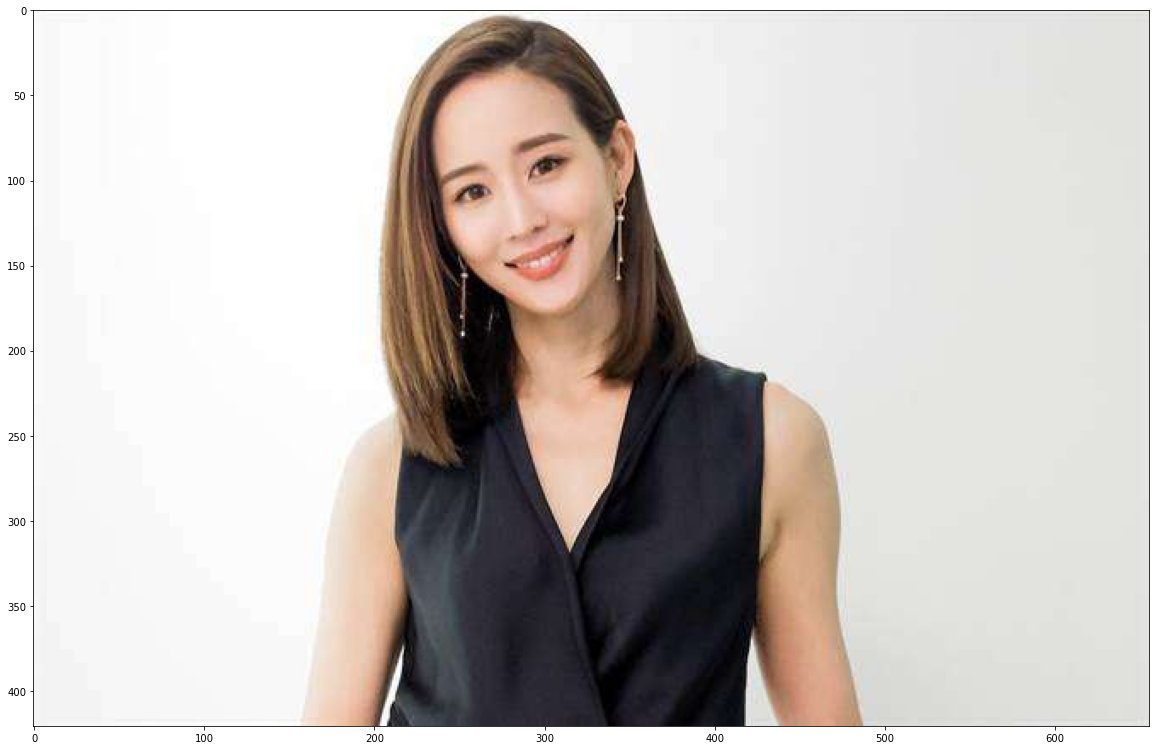

,x1,y1,x2,y2,class_name,score,w,h


In [7]:
model.predict('dataset/train_img2/test3.jpg')

img shape:  (480, 640, 3)
# of bboxes: 0


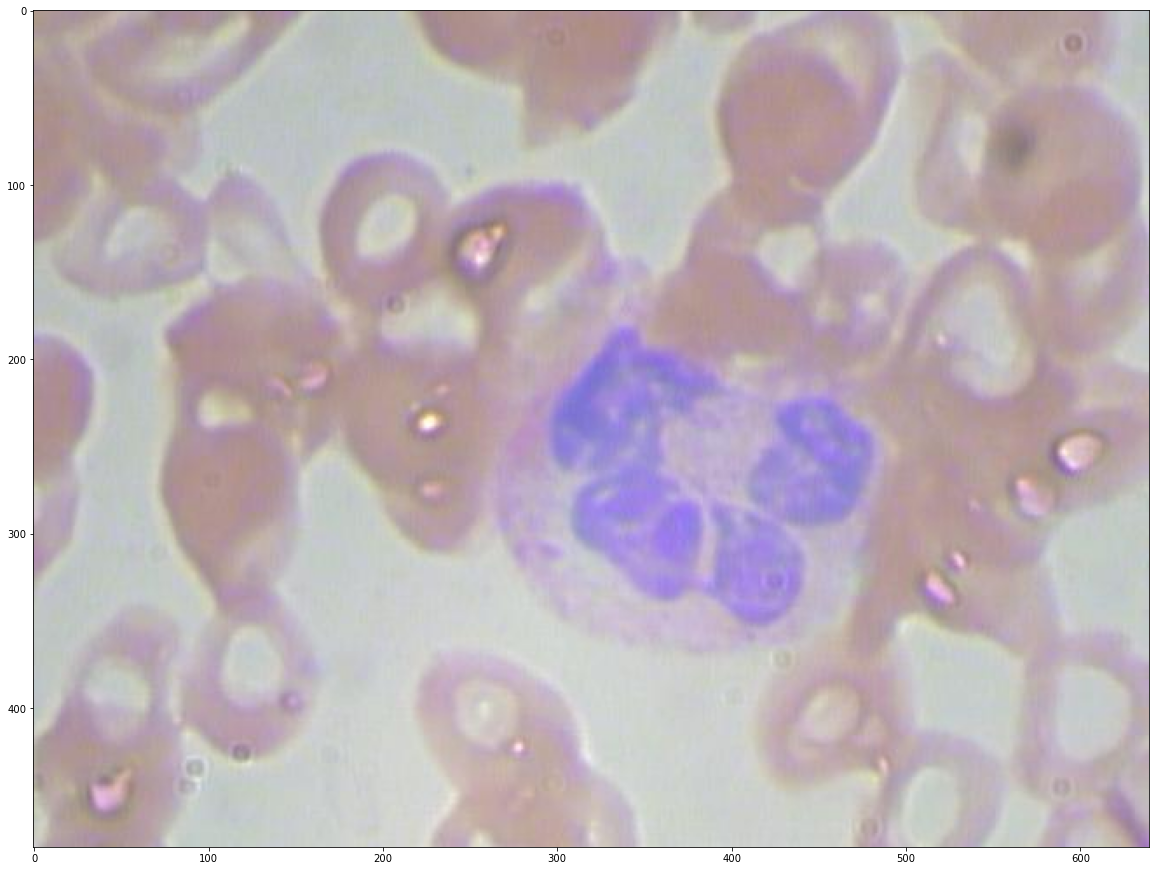

,x1,y1,x2,y2,class_name,score,w,h


In [8]:
model.predict('dataset/train_img/BloodImage_00000.jpg')

In [6]:
pred = model.predict_raw('dataset/train_img2/test3.jpg')
pred = [p.reshape(1, p.shape[1], p.shape[2], 3, 5+NUM_CLASS) for p in pred]

img shape:  (421, 656, 3)


In [8]:
pred[0].shape, pred[1].shape, pred[2].shape

((1, 52, 52, 3, 85), (1, 26, 26, 3, 85), (1, 13, 13, 3, 85))

In [11]:
pred[2][0, 6, 6, :, 4:5]

array([[ 0.06934599],
       [-0.09441224],
       [ 0.05418041]], dtype=float32)

img shape:  (480, 640, 3)
# of bboxes: 0


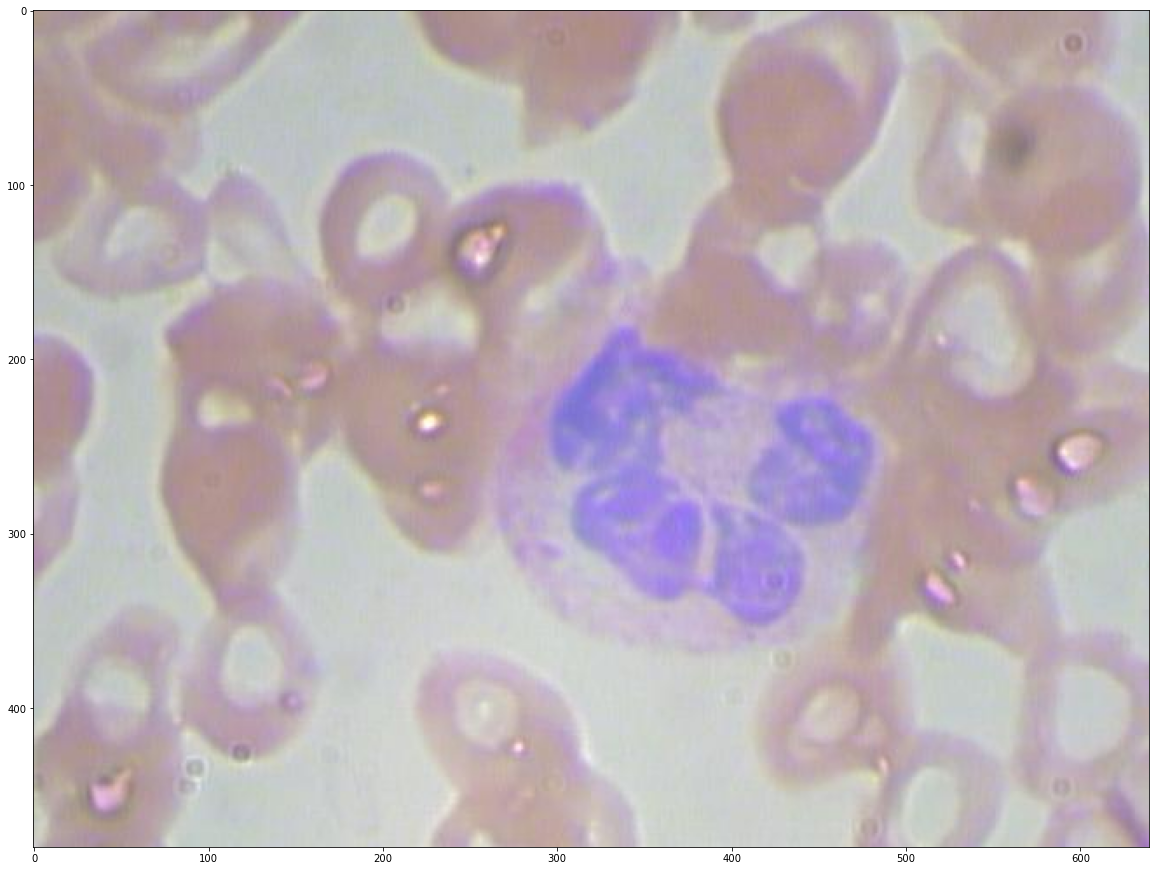

,x1,y1,x2,y2,class_name,score,w,h


In [22]:
model.predict('dataset/train_img/BloodImage_00000.jpg')

img shape:  (421, 656, 3)
# of bboxes: 100


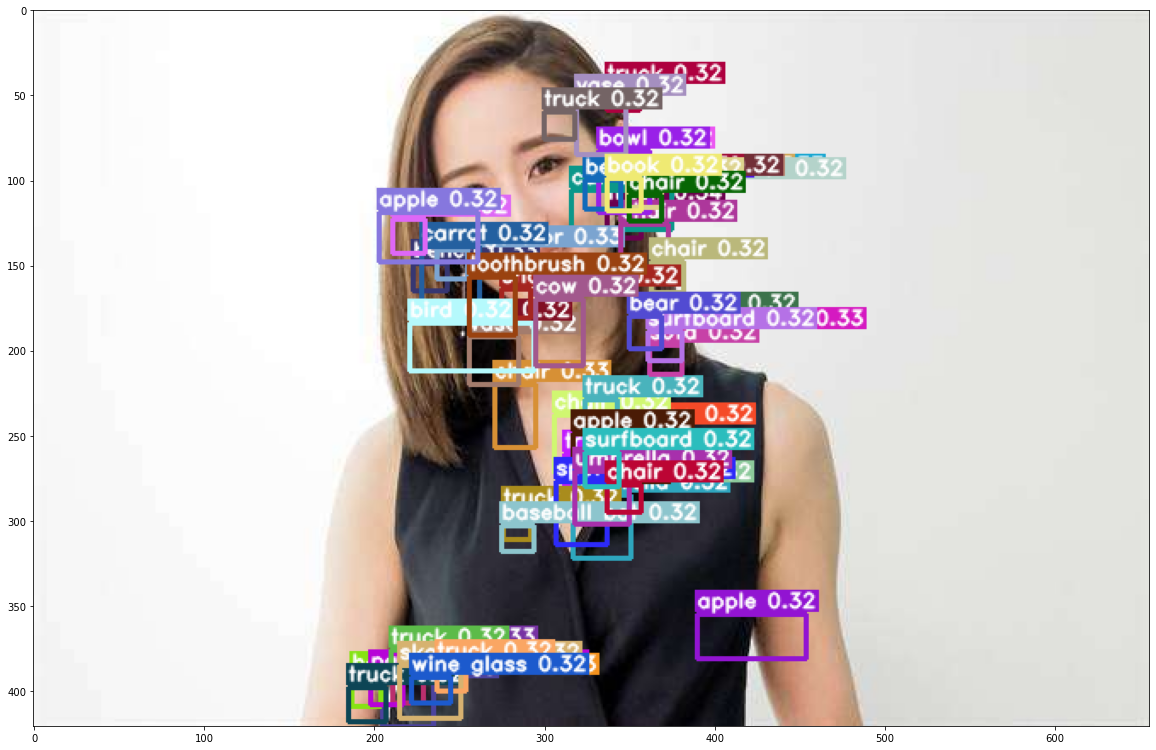

,x1,y1,x2,y2,class_name,score,w,h
0,337,99,357,118,parking meter,0.346773,20,19
1,337,115,357,134,truck,0.341281,20,19
2,337,99,357,118,bus,0.335009,20,19
3,361,189,381,206,truck,0.334909,20,17
4,361,189,381,206,hot dog,0.334442,20,17
...,...,...,...,...,...,...,...,...
95,318,271,350,302,umbrella,0.317588,32,31
96,222,392,245,407,wine glass,0.317585,23,15
97,295,170,323,209,cow,0.317561,28,39
98,337,279,357,295,chair,0.317535,20,16


In [9]:
model.predict('dataset/train_img2/test3.jpg')

In [0]:
# losses = [yolo_loss_wrapper(input_shape=(416, 416), 
#                   STRIDES=[8, 16, 32][i], 
#                   NUM_CLASS=NUM_CLASS,
#                   ANCHORS=anchors.reshape(3, 3, 2)[i], 
#                   XYSCALES=[1., 1., 1.][i], 
#                   IOU_LOSS_THRESH=0.5) for i in range(3)]


# # # In[31]:
# INIT_LR = 1e-4 # 1e-6
# FINAL_LR = 1e-4 # 1e-8
# opt = tf.keras.optimizers.Adam(lr=1e-4)
# opt2 = tf.keras.optimizers.Adam(lr=1e-4)
# opt3 = tf.keras.optimizers.Adam(lr=1e-4)
# steps_per_epoch = len(lines) // BS
# warmup_epochs = 20
# warmup_steps = warmup_epochs * steps_per_epoch
# global_steps = 0
# first_stage_epoch = 200
# second_stage_epoch = 300
# total_steps = (first_stage_epoch + second_stage_epoch) * steps_per_epoch

# y_true = [
#     tf.keras.layers.Input(name='input_2', shape=(52, 52, 3, (NUM_CLASS + 5))),  # label_sbbox
#     tf.keras.layers.Input(name='input_3', shape=(26, 26, 3, (NUM_CLASS + 5))),  # label_mbbox
#     tf.keras.layers.Input(name='input_4', shape=(13, 13, 3, (NUM_CLASS + 5))),  # label_lbbox
#     tf.keras.layers.Input(name='input_5', shape=(100, 4)),             # true_bboxes
# ]
# loss_list = tf.keras.layers.Lambda(yolo_loss2, name='yolo_loss',
#                         arguments={'num_classes': NUM_CLASS, 'iou_loss_thresh': 0.5,
#                                     'anchors': anchors.reshape((3, 3, 2))})([*model.yolo_model.output, *y_true])
# model2 = tf.keras.models.Model([model.yolo_model.input, *y_true], loss_list)

# model2.compile(loss={'yolo_loss': lambda y_true, y_pred: y_pred}, optimizer=tf.keras.optimizers.Adam(lr=1e-4))